In [2]:
import numpy as np
from matplotlib import pyplot as plt

Te=24*3600 # 1 day in seconds

c=299792458.
G=6.6743e-11
Mpc=3.086e22
Msun=1.989e30

# GW POLARIZATIONS

def nhat(theta,phi):
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
def phat(theta,phi):
    return np.array([np.sin(phi),-np.cos(phi),0.])
def qhat(theta,phi):
    return np.array([np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)])
def ep(theta,phi):
    return np.einsum('i,j->ij', phat(theta,phi),phat(theta,phi))-np.einsum('i,j->ij', qhat(theta,phi),qhat(theta,phi))
def ec(theta,phi):
    return np.einsum('i,j->ij', phat(theta,phi),qhat(theta,phi))+np.einsum('i,j->ij', qhat(theta,phi),phat(theta,phi))

# GW AMPLITUDES

def chirp_mass(m1,m2):
    return ((m1*m2)**(3/5)) / ((m1+m2)**(1/5))

def hp(t,*h_pars):
    tcoal,Mc,phi0,r,iota=h_pars
    c_times_tau=c*(tcoal-t)*(tcoal>t)
    phih=-2.*(c_times_tau/(5*Mc*Msun*G/c**2))**(5/8) +phi0
    return (
        (r*Mpc)**(-1)
        *(Mc*Msun*G/c**2)**(5/4)
        *(c_times_tau/5+1e-8)**(-1/4)
        *(1+np.cos(iota)**2)/2
        *np.cos(phih)
    )

def hc(t,*h_pars):
    tcoal,Mc,phi0,r,iota=h_pars
    c_times_tau=c*(tcoal-t)*(tcoal>t)
    phih=-2.*(c_times_tau/(5*Mc*Msun*G/c**2))**(5/8) +phi0
    return (
        (r*Mpc)**(-1)
        *(Mc*Msun*G/c**2)**(5/4)
        *(c_times_tau/5+1e-8)**(-1/4)
        *np.cos(iota)
        *np.sin(phih)
    )

# DETECTOR SHIT

theta_ET0=np.pi/2-40.4423*np.pi/180
phi_ET0=9.44899*np.pi/180
beta_ET0=0

posET0=nhat(theta_ET0,phi_ET0)
vNET=np.array([-np.cos(theta_ET0)*np.cos(phi_ET0),-np.cos(theta_ET0)*np.sin(phi_ET0),np.sin(theta_ET0)])
vEET=np.array([-np.sin(phi_ET0),np.cos(phi_ET0),0])

# matc=np.array([[4/(3*np.sqrt(3)),-2/(3*np.sqrt(3)),-2/(3*np.sqrt(3))],[0,-2/3,2/3],[(2/3)**1.5,(2/3)**1.5,(2/3)**1.5]])

def rotm(t):
    return np.array([[np.cos(2*np.pi*t/Te),-np.sin(2*np.pi*t/Te),0],
                 [np.sin(2*np.pi*t/Te),np.cos(2*np.pi*t/Te),0],
                [0,0,1]])

def rot(v,t): # Rotates a vector around Earth's axis
    return np.dot(rotm(t),v)
    
def beta_ET(alp): 
    return beta_ET0+2*np.pi*alp/3

def uhat(alp,t):
    return np.cos(beta_ET(alp))*rot(vNET,t)+np.sin(beta_ET(alp))*rot(vEET,t)

def dab_X(t):
    first=np.einsum('i,j->ij', uhat(0,t), uhat(0,t))
    second=np.einsum('i,j->ij', uhat(2,t), uhat(2,t))
    return (first-second)/2

def dab_Y(t):
    first=np.einsum('i,j->ij', uhat(1,t), uhat(1,t))
    second=np.einsum('i,j->ij', uhat(0,t), uhat(0,t))
    return (first-second)/2

def dab_A(t):
    return dab_X(t)*2/np.sqrt(3)

def dab_E(t):
    return -(dab_X(t)+2*dab_Y(t))*2/3


# THE SIGNAL s(t) for the two channels A, E


def sA(t,*pars):
    theta,phi,*h_pars=pars
    ee=hp(t,*h_pars)*ep(theta,phi)+hc(t,*h_pars)*ec(theta,phi)
    return np.einsum('ij,ij->',ee,dab_A(t))

def sE(t,*pars):
    theta,phi,*h_pars=pars
    ee=hp(t,*h_pars)*ep(theta,phi)+hc(t,*h_pars)*ec(theta,phi)
    return np.einsum('ij,ij->',ee,dab_E(t))

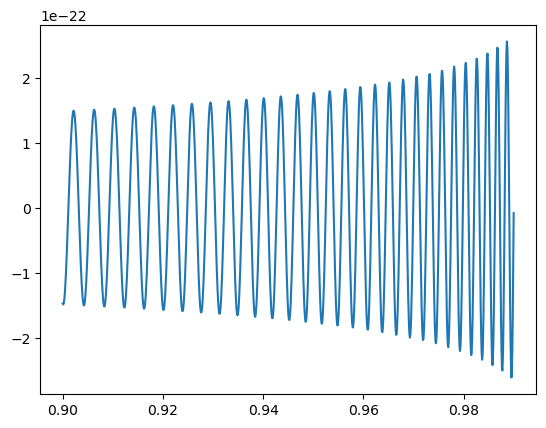

In [3]:
myhpars=1,1.9,0.,40.,1.
mypars=1.,1.,*myhpars
mytimes=np.linspace(0.9,0.99,1000)
myhs=np.array([sE(t,*mypars) for t in mytimes])
plt.plot(mytimes,myhs)

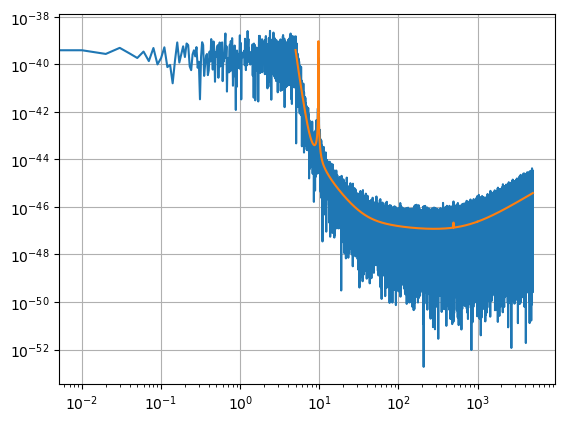

In [4]:
from scipy.fft import fft, fftfreq

def piecewise_logarithmic(frequencies, psds):

    # Convert to log space
    log_frequencies = np.log(frequencies)
    log_psds = np.log(psds)

    
    def colour(f):
        with np.errstate(divide="ignore"):
            return np.exp(np.interp(np.log(f), log_frequencies, log_psds))
    return colour

def _base_noise(dt, n):
    
    f = np.fft.rfftfreq(n, dt)
    x_f = rng.normal(0,0.5, len(f)) + 1j * rng.normal(0, 0.5, len(f))
    x_f *= np.sqrt(n / dt)
    
    x_f[0] = np.abs(x_f[0])
    if len(f) % 2 == 0:
        x_f[-1] = np.abs(x_f[-1])

    return f, x_f
    
    
def generate(dt, n, colour=None):
    f, x_f = _base_noise(dt, n)
    if colour:
        x_f *= np.sqrt(colour(f))
    return np.fft.irfft(x_f)
    
rng = np.random.default_rng()

f_and_psd=np.loadtxt('LIGOL.txt', dtype='double')
freqs_psd=f_and_psd[:,0]
psd_psd=(f_and_psd[:,1])**2

colour = piecewise_logarithmic(freqs_psd, psd_psd)

# Number of sample points
N = 1000000
# sample spacing
T = 1.0 / 10000.0


custom = generate(T, N, colour=colour)

yf = fft(custom)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.loglog(xf, 2.0/N*T * np.abs(yf[0:N//2])**2)
plt.loglog(freqs_psd,psd_psd)

plt.grid()
plt.show()

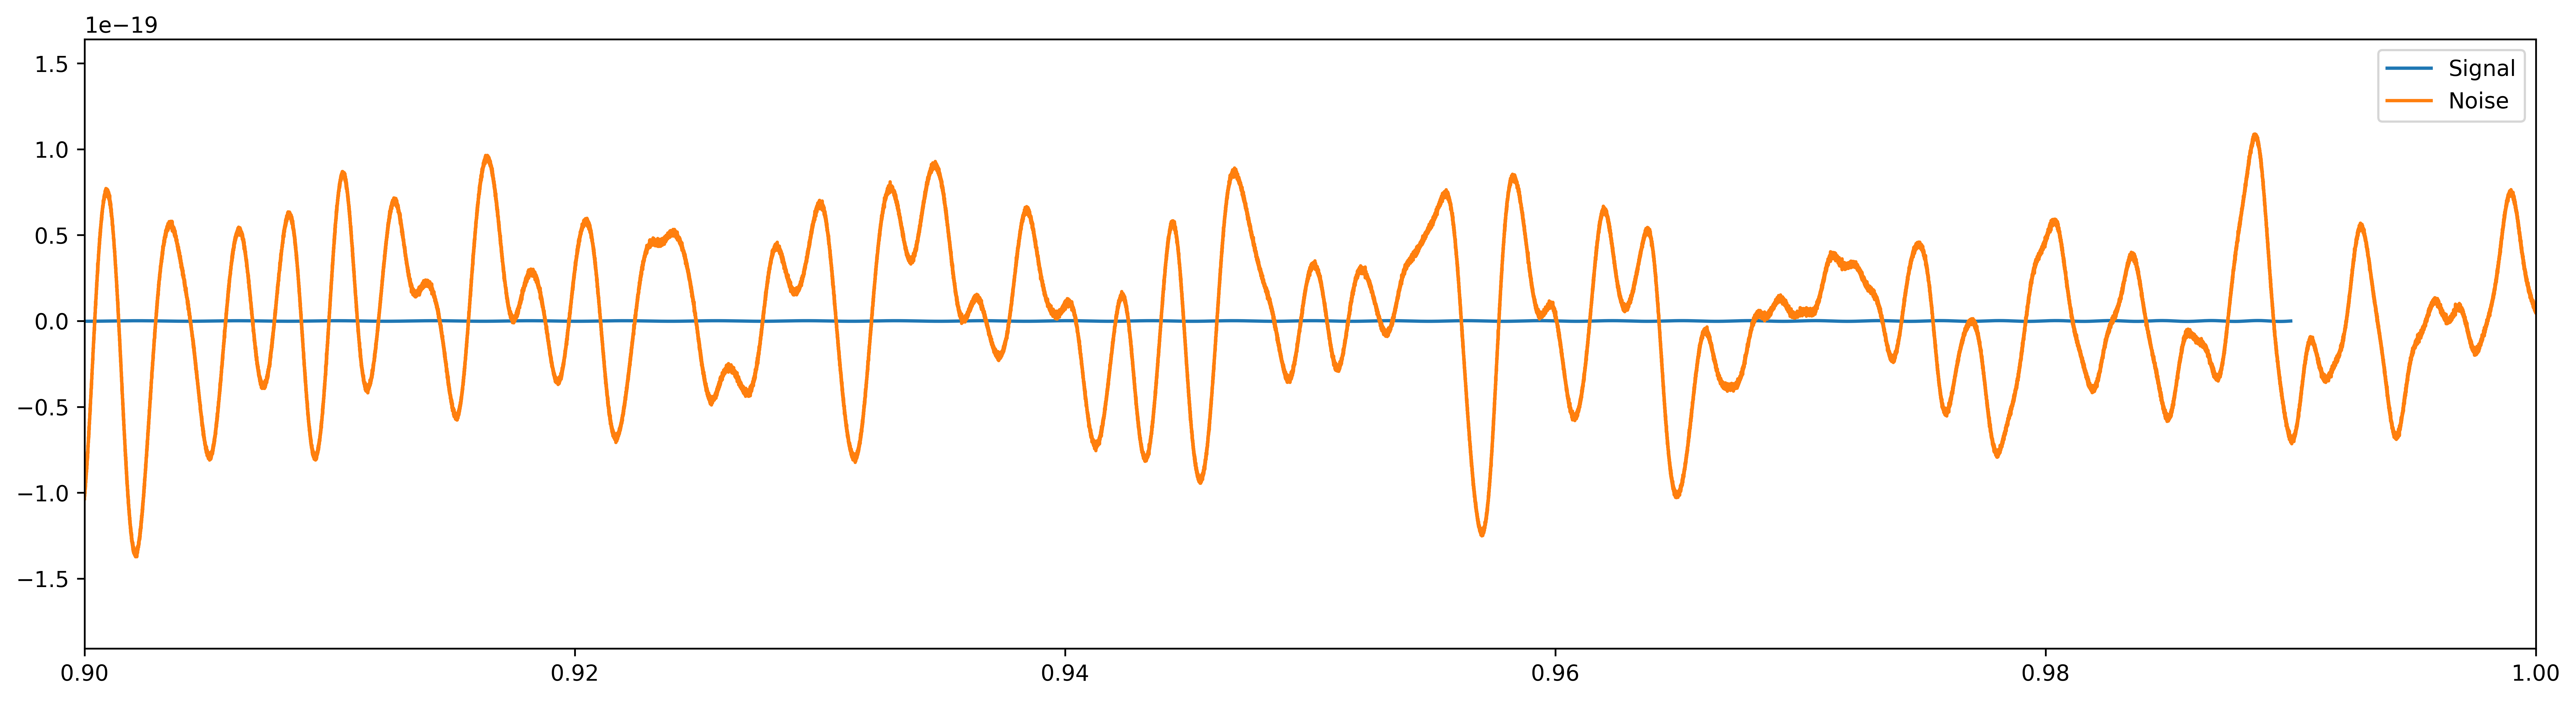

In [13]:
plt.figure(figsize=(20,5), dpi=600)
plt.plot(mytimes,myhs, label='Signal')
plt.plot(np.linspace(0,1.,N),custom, label='Noise')
plt.xlim(0.9,1)
plt.legend()
plt.show()